In [2]:
# import Required Libraries 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime 
from sklearn.preprocessing import LabelEncoder 
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
import seaborn as sns 
from keras.layers import Dense, BatchNormalization, Dropout, LSTM 
from keras.models import Sequential 
from keras.utils import to_categorical 
from keras.optimizers import Adam 
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score 
from keras import callbacks 
 
np.random.seed(0) 


In [3]:
import pandas as pd

data = pd.read_csv("dataset/seattle-weather.csv")
data.head()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


C:\Users\inteL\AppData\Local\Temp\ipykernel_10068\1585154393.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data["RainTomorrow"], palette=cols)


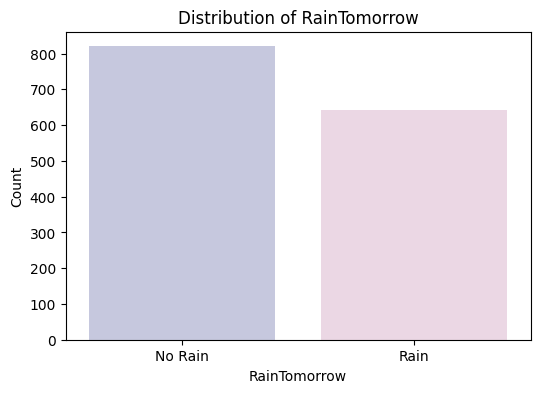

RainTomorrow
0    820
1    641
Name: count, dtype: int64


In [4]:
#  TARGET VARIABLE RainTomorrow: 1 = Rain, 0 = No Rain
data["RainTomorrow"] = data["weather"].apply(lambda x: 1 if x == "rain" else 0)

cols = ["#C2C4E2", "#EED4E5"]

plt.figure(figsize=(6, 4))
sns.countplot(x=data["RainTomorrow"], palette=cols)
plt.xticks([0, 1], ["No Rain", "Rain"])
plt.title("Distribution of RainTomorrow")
plt.xlabel("RainTomorrow")
plt.ylabel("Count")
plt.show()

print(data["RainTomorrow"].value_counts())

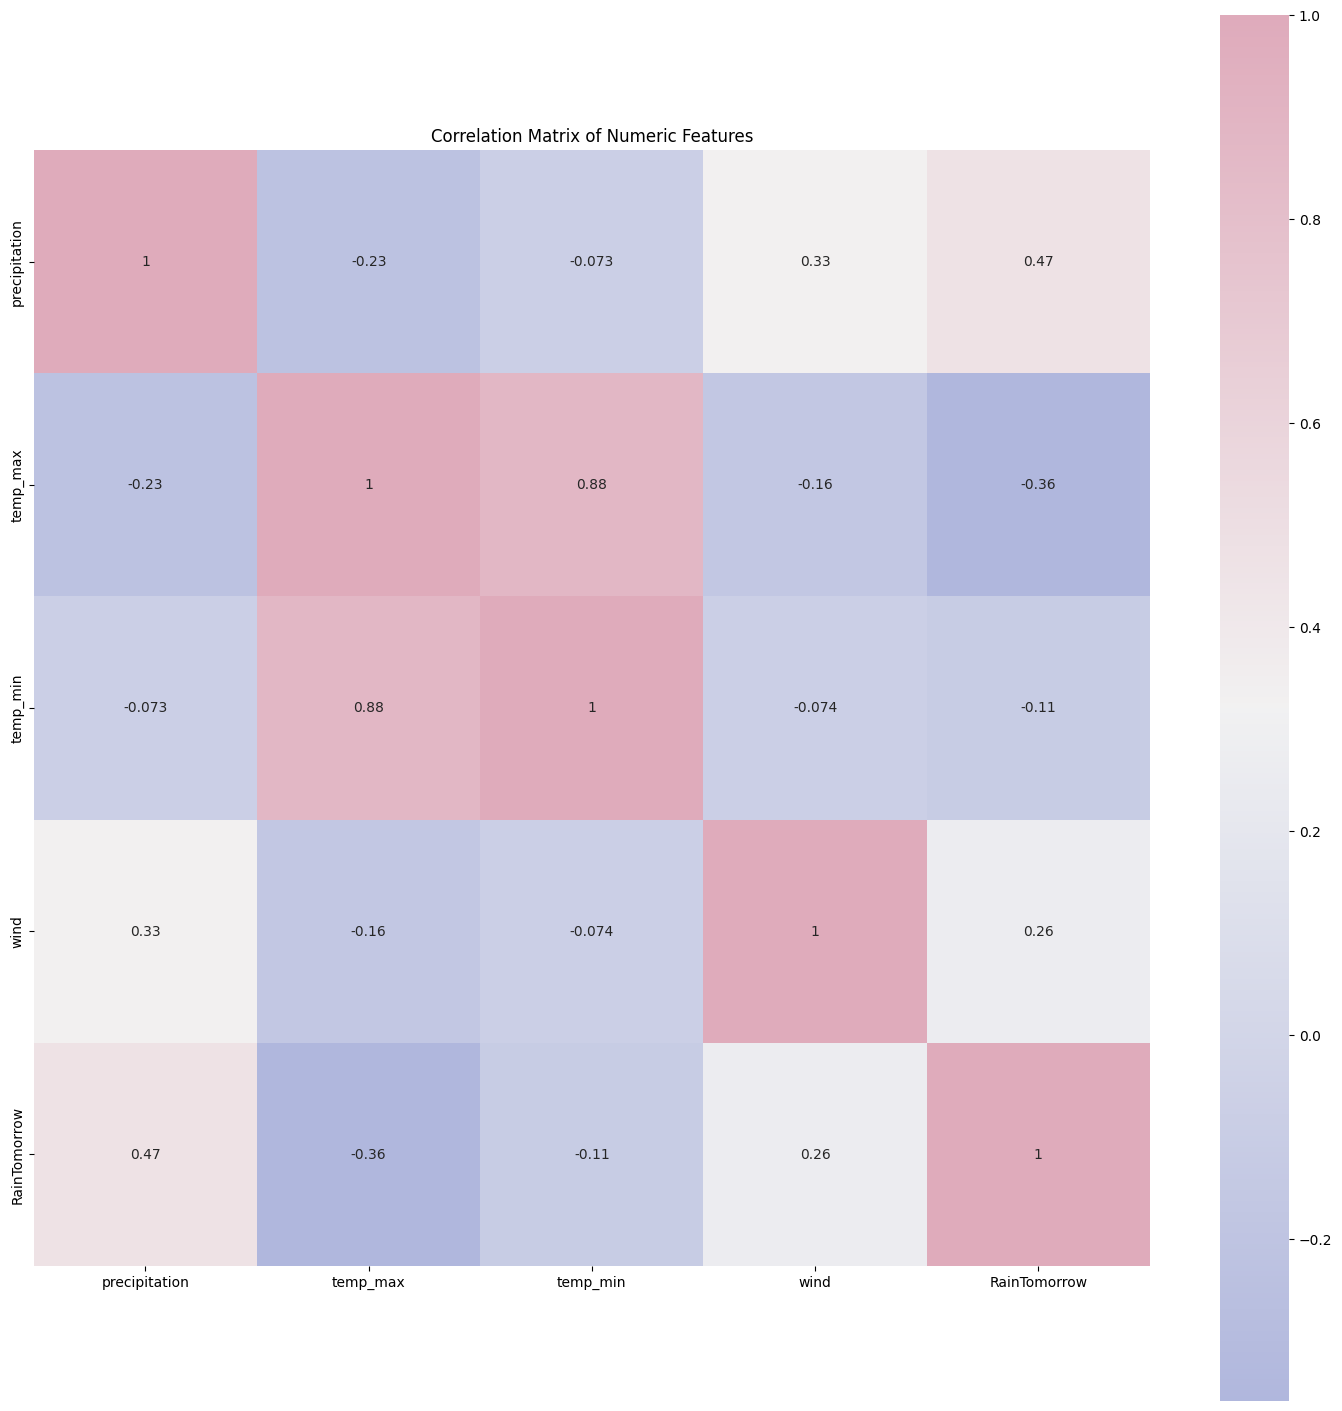

In [6]:
# Ambil hanya kolom numerik
numeric_data = data.select_dtypes(include=["int64", "float64"])

# Hitung korelasi
corrmat = numeric_data.corr()

# Color map
cmap = sns.diverging_palette(260, -10, s=50, l=75, n=6, as_cmap=True)

# Plot heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(corrmat, cmap=cmap, annot=True, square=True)
plt.title("Correlation Matrix of Numeric Features")
plt.show()


In [7]:
# Pastikan kolom date ada
print(data.columns)

# Ubah ke string sementara untuk cek panjang tanggal
date_str = data["date"].astype(str)
lengths = date_str.str.len()
print(lengths.value_counts())

# Parsing ke datetime (aman walau sudah datetime)
data["date"] = pd.to_datetime(data["date"])

# Creating a column of year
data["year"] = data.date.dt.year

# function to encode datetime into cyclic parameters
def encode(data, col, max_val):
    data[col + "_sin"] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + "_cos"] = np.cos(2 * np.pi * data[col] / max_val)
    return data

# Month
data["month"] = data.date.dt.month
data = encode(data, "month", 12)

# Day
data["day"] = data.date.dt.day
data = encode(data, "day", 31)

# Preview dataset
data.head()

Index(['date', 'precipitation', 'temp_max', 'temp_min', 'wind', 'weather',
       'RainTomorrow'],
      dtype='object')
date
10    1461
Name: count, dtype: int64


,date,precipitation,temp_max,temp_min,wind,weather,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle,0,2012,1,0.5,0.866025,1,0.201299,0.979530
1,2012-01-02,10.9,10.6,2.8,4.5,rain,1,2012,1,0.5,0.866025,2,0.394356,0.918958
2,2012-01-03,0.8,11.7,7.2,2.3,rain,1,2012,1,0.5,0.866025,3,0.571268,0.820763
3,2012-01-04,20.3,12.2,5.6,4.7,rain,1,2012,1,0.5,0.866025,4,0.724793,0.688967
4,2012-01-05,1.3,8.9,2.8,6.1,rain,1,2012,1,0.5,0.866025,5,0.848644,0.528964


Text(0.5, 0, 'Sine Encoded Months')

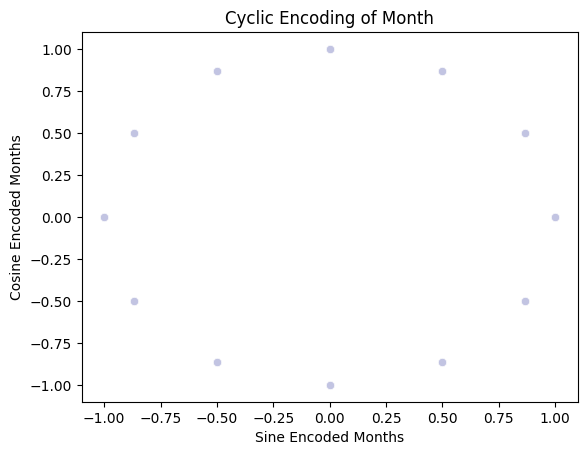

In [8]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#C2C4E2") 
cyclic_month.set_title("Cyclic Encoding of Month") 
cyclic_month.set_ylabel("Cosine Encoded Months") 
cyclic_month.set_xlabel("Sine Encoded Months") 

Text(0.5, 0, 'Sine Encoded Day')

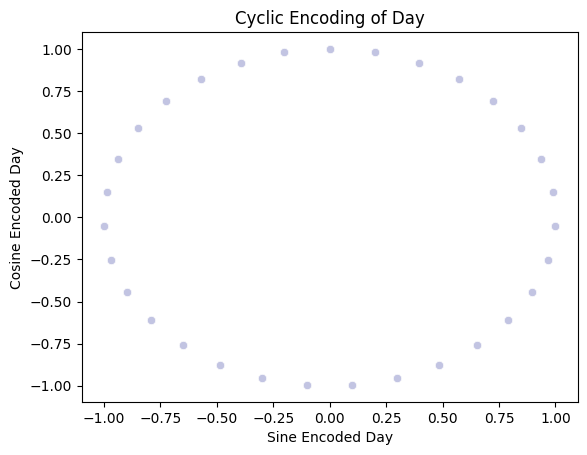

In [9]:
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#C2C4E2") 
cyclic_day.set_title("Cyclic Encoding of Day") 
cyclic_day.set_ylabel("Cosine Encoded Day") 
cyclic_day.set_xlabel("Sine Encoded Day") 

In [10]:
# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

# Missing values in categorical variables
for col in object_cols:
    print(col, data[col].isnull().sum())

# Filling missing values with mode
# (Exclude date column if still object)
for col in object_cols:
    if col != "date": 
        data[col] = data[col].fillna(data[col].mode()[0])


Categorical variables:
['weather']
weather 0


In [11]:
# Get list of neumeric variables 
t = (data.dtypes == "float64") 
num_cols = list(t[t].index) 
 
print("Neumeric variables:") 
print(num_cols) 
# Missing values in numeric variables 
 
for i in num_cols: 
    print(i, data[i].isnull().sum()) 
    
     
data.info() 

Neumeric variables:
['precipitation', 'temp_max', 'temp_min', 'wind', 'month_sin', 'month_cos', 'day_sin', 'day_cos']
precipitation 0
temp_max 0
temp_min 0
wind 0
month_sin 0
month_cos 0
day_sin 0
day_cos 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1461 non-null   datetime64[ns]
 1   precipitation  1461 non-null   float64       
 2   temp_max       1461 non-null   float64       
 3   temp_min       1461 non-null   float64       
 4   wind           1461 non-null   float64       
 5   weather        1461 non-null   object        
 6   RainTomorrow   1461 non-null   int64         
 7   year           1461 non-null   int32         
 8   month          1461 non-null   int32         
 9   month_sin      1461 non-null   float64       
 10  month_cos      1461 non-null   float64       
 11  day            146

In [12]:
# ENCODING CATEGORICAL DATA

# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

# Apply LabelEncoder per column
for col in object_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Check result
data.info()


# PREPARING FEATURES & TARGET
# Drop target & non-feature columns
features = data.drop(
    columns=[
        'RainTomorrow',  # target
        'date',          # datetime
        'month', 'day'   # raw temporal features (already cyclic encoded)
    ]
)

target = data['RainTomorrow']


# FEATURE SCALING
scaler = StandardScaler()
col_names = features.columns

features_scaled = scaler.fit_transform(features)
features = pd.DataFrame(features_scaled, columns=col_names)

# Feature summary
features.describe().T

Categorical variables:
['weather']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1461 non-null   datetime64[ns]
 1   precipitation  1461 non-null   float64       
 2   temp_max       1461 non-null   float64       
 3   temp_min       1461 non-null   float64       
 4   wind           1461 non-null   float64       
 5   weather        1461 non-null   int64         
 6   RainTomorrow   1461 non-null   int64         
 7   year           1461 non-null   int32         
 8   month          1461 non-null   int32         
 9   month_sin      1461 non-null   float64       
 10  month_cos      1461 non-null   float64       
 11  day            1461 non-null   int32         
 12  day_sin        1461 non-null   float64       
 13  day_cos        1461 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int

,count,mean,std,min,25%,50%,75%,max
precipitation,1461.0,2.674870e-17,1.000342,-0.453650,-0.453650,-0.453650,-0.034357,7.917235
temp_max,1461.0,9.726800e-18,1.000342,-2.455218,-0.794731,-0.114204,0.784092,2.607906
temp_min,1461.0,0.000000e+00,1.000342,-3.053954,-0.763703,0.012991,0.789684,2.004513
wind,1461.0,-8.754120e-17,1.000342,-1.976672,-0.724353,-0.167766,0.527967,4.354498
weather,1461.0,1.459020e-16,1.000342,-2.310905,-0.631605,-0.631605,1.047695,1.047695
year,1461.0,-7.143362e-14,1.000342,-1.340356,-1.340356,-0.446173,0.448009,1.342192
month_sin,1461.0,-3.890720e-17,1.000342,-1.410136,-1.220305,0.006779,0.715237,1.423695
month_cos,1461.0,-1.556288e-16,1.000342,-1.408701,-1.219587,0.002864,1.225315,1.414429
day_sin,1461.0,1.762982e-17,1.000342,-1.402028,-1.018009,-0.001908,1.014193,1.398212
day_cos,1461.0,3.586757e-17,1.000342,-1.393941,-1.056934,-0.046233,1.009439,1.453384


C:\Users\inteL\AppData\Local\Temp\ipykernel_10068\3759624841.py:5: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.boxenplot(data = features,palette = colours)


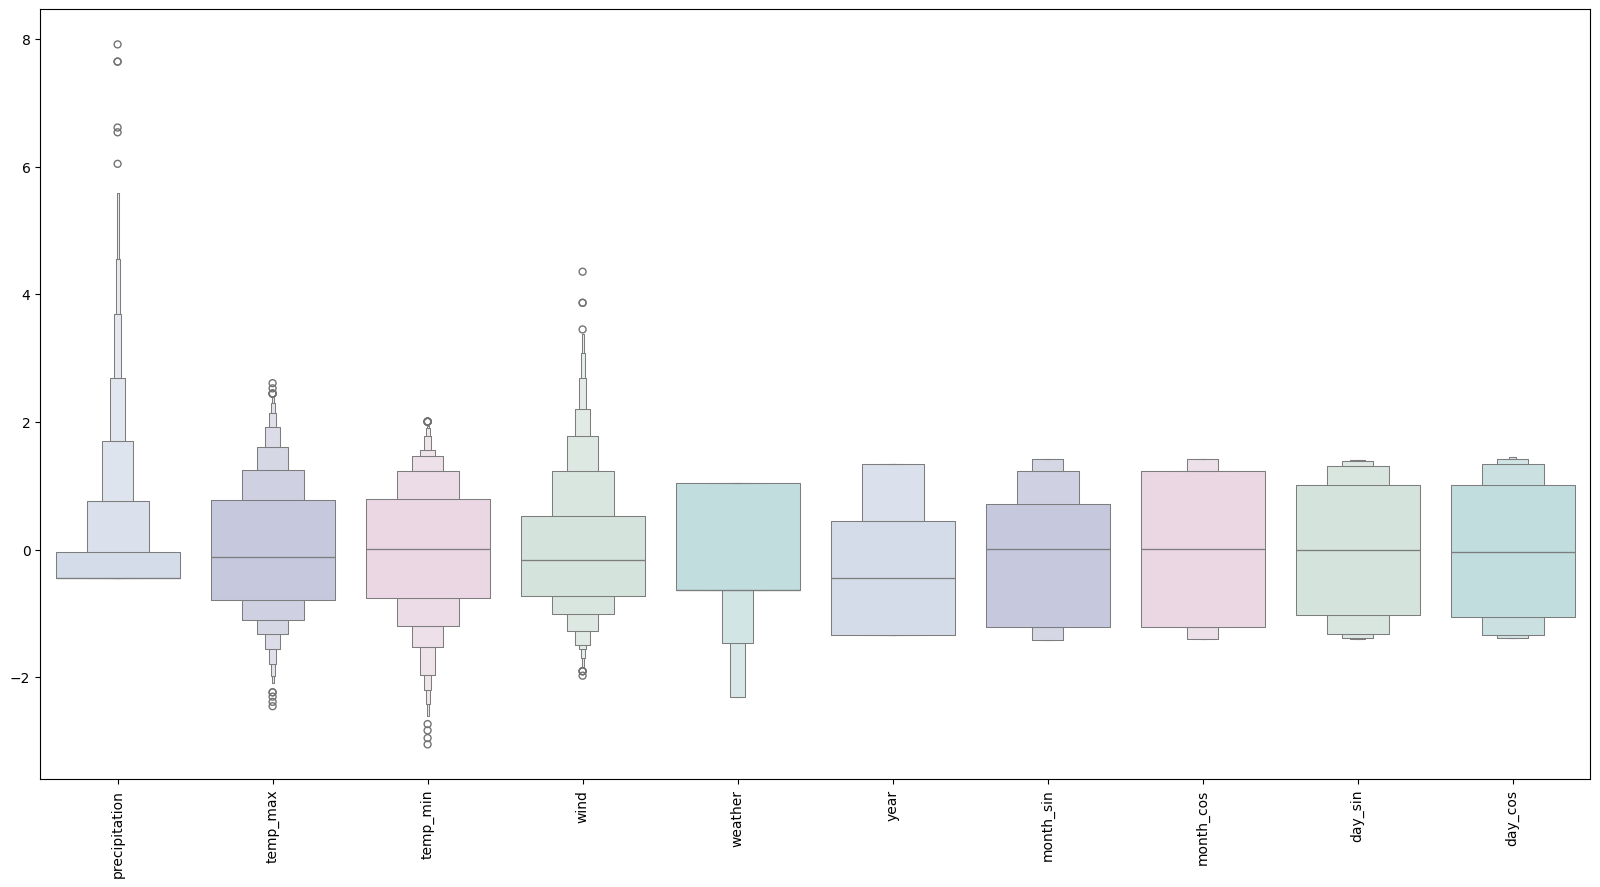

In [13]:
#Detecting outliers 
#looking at the scaled features 
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"] 
plt.figure(figsize=(20,10)) 
sns.boxenplot(data = features,palette = colours) 
plt.xticks(rotation=90) 
plt.show() 

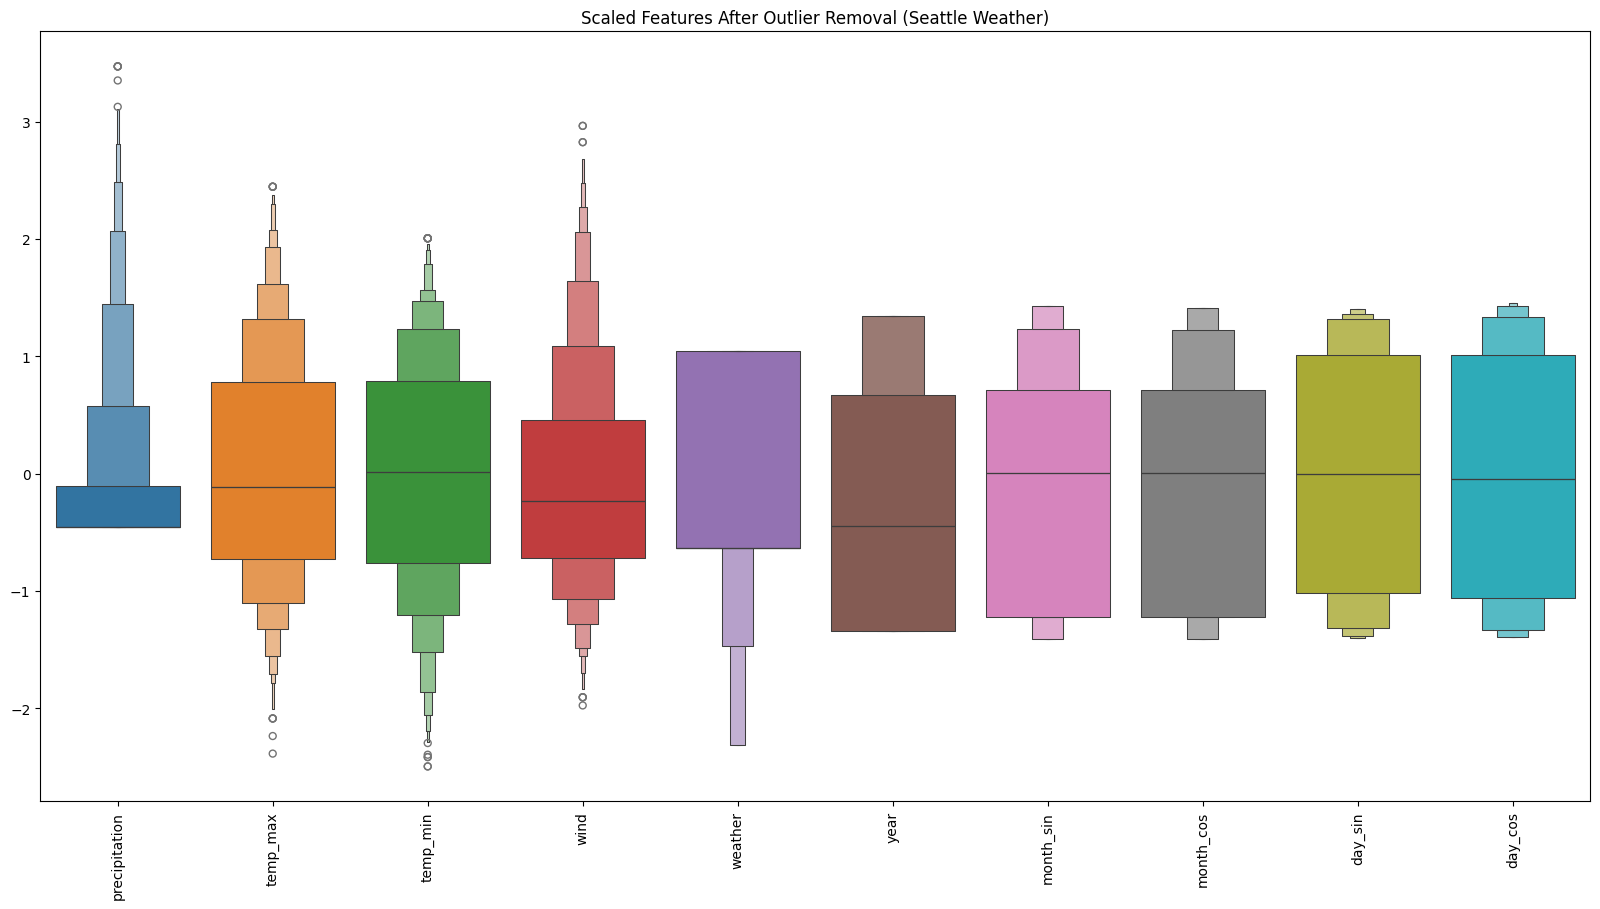

In [14]:
# Gabungkan kembali target ke features
features["RainTomorrow"] = target.values

# Removing outliers (Z-score threshold)
features = features[
    (features["temp_min"] > -2.5) & (features["temp_min"] < 2.5)
]

features = features[
    (features["temp_max"] > -2.5) & (features["temp_max"] < 2.5)
]

features = features[
    (features["precipitation"] < 3.5)
]

features = features[
    (features["wind"] < 3)
]

# Shape after outlier removal
features.shape

plt.figure(figsize=(20,10))
sns.boxenplot(data=features.drop(columns=["RainTomorrow"]))
plt.xticks(rotation=90)
plt.title("Scaled Features After Outlier Removal (Seattle Weather)")
plt.show()


Input features: 10


c:\Users\inteL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5133 - loss: 0.7024 - val_accuracy: 0.5752 - val_loss: 0.6926
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5244 - loss: 0.6960 - val_accuracy: 0.5708 - val_loss: 0.6905
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5311 - loss: 0.6924 - val_accuracy: 0.5708 - val_loss: 0.6886
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5367 - loss: 0.6938 - val_accuracy: 0.5973 - val_loss: 0.6871
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5433 - loss: 0.6899 - val_accuracy: 0.5973 - val_loss: 0.6856
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5344 - loss: 0.6857 - val_accuracy: 0.5885 - val_loss: 0.6840
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5311 - loss: 0.6941 - val_accuracy: 0.5841 - val_loss: 0.6827
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5467 - loss: 0.6843 - val_accuracy: 0.5796 - val_los

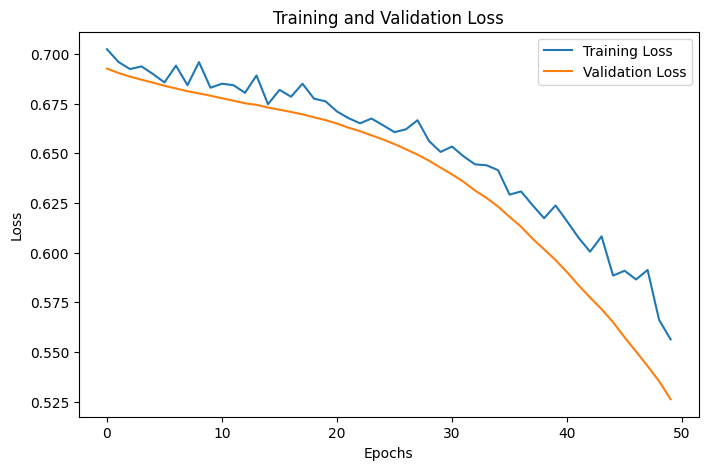

In [15]:
# MODEL BUILDING
X = features.drop(columns=["RainTomorrow"])
y = features["RainTomorrow"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Input features:", X_train.shape[1])

# EARLY STOPPING
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    restore_best_weights=True
)

# BUILD ANN MODEL
model = Sequential()

model.add(Dense(32, activation="relu", input_dim=X_train.shape[1]))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(8, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

# COMPILE MODEL
opt = Adam(learning_rate=0.00009)
model.compile(
    optimizer=opt,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# TRAIN MODEL
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# TRAINING HISTORY
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(8,5))
plt.plot(history_df["loss"], label="Training Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


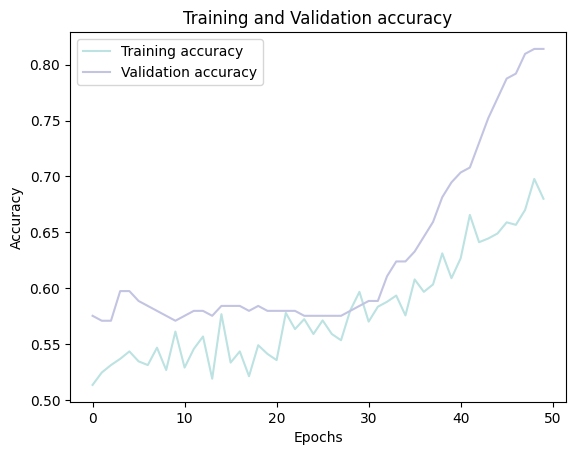

In [16]:
history_df = pd.DataFrame(history.history) 
 
plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy') 
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy') 
 
plt.title('Training and Validation accuracy') 
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend() 
plt.show() 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


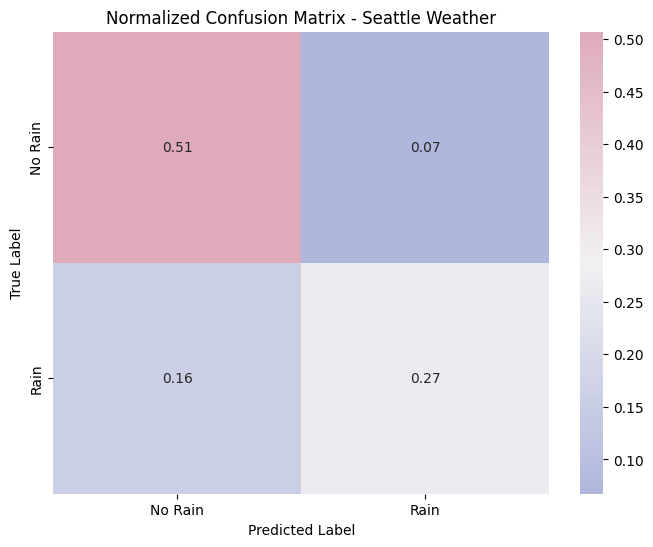

              precision    recall  f1-score   support

     No Rain       0.76      0.88      0.82       162
        Rain       0.80      0.62      0.70       120

    accuracy                           0.77       282
   macro avg       0.78      0.75      0.76       282
weighted avg       0.78      0.77      0.77       282



In [17]:
# PREDICTION
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# CONFUSION MATRIX
cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cf_matrix / np.sum(cf_matrix),
    annot=True,
    fmt=".2f",
    cmap=sns.diverging_palette(260, -10, s=50, l=75, as_cmap=True),
    xticklabels=["No Rain", "Rain"],
    yticklabels=["No Rain", "Rain"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix - Seattle Weather")
plt.show()

# CLASSIFICATION REPORT
print(classification_report(y_test, y_pred, target_names=["No Rain", "Rain"]))


In [18]:
import joblib

# Save model
model.save("model_ann.h5")

# Save scaler
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']